# 1. The Vanishing/Exploding Gradients Problems
불안정한 그레디언트는 심층 신경망 학습을 어렵게 한다. 층마다 학습 속도가 달라질 수 있기 때문이다.
[그레디언트 소실(Vanishing Gradient)]<br>
경사하강법 알고리즘이 하위층으로 진행될수록 그레디언트가 점점 작아지는 경우가 많다. 경사하강법이 하위층의 연결 가중치를 변경되지 않은 채로 둔다면 훈련이 좋은 솔루션으로 수렴되지 않을 것이다.<br>
[그레디언트 폭주(Exploding Gradient)]<br>
그레디언트 소실과 반대의 경우다. 경사 하강법이 하위층으로 진행될수록 그레디언트가 점점 커져서 여러 층이 비정상적으로 큰 가중치로 갱신되면 알고리즘은 발산한다. 주로 RNN(순환신경망)에서 나타난다.<br>

## Glorot and He Initialization
Glorot and Bengio는 논문에서 불안정한 그레디언트 문제를 완화하는 방법을 제시했다. 이들은 정방향, 역방향으로 적절한 신호가 흐르기 위해서는 **각 층의 출력에 대한 분산이 입력에 대한 분산과 같아야 한다**고 주장한다. 그리고 역방향에서 층을 통과하기 전과 후의 그레디언트 분산이 동일해야 한다. 사실 입력과 출력의 연결 개수가 같지 않다면 이 두 가지를 보장할 수 없다. 하지만 글로럿과 벤지오는 **각 층의 연결 가중치를 무작위 초기화** 하는 방법을 제안하여 전자의 문제를 해결했다.   
* 글로럿 초기화를 사용하면 훈련 속도를 상당히 높일 수 있다.   
* ReLu 활성함수에 대한 초기화 전략을 He initialization이라고 부른다.(이름은 논문의 저자이름을 딴 것임)   
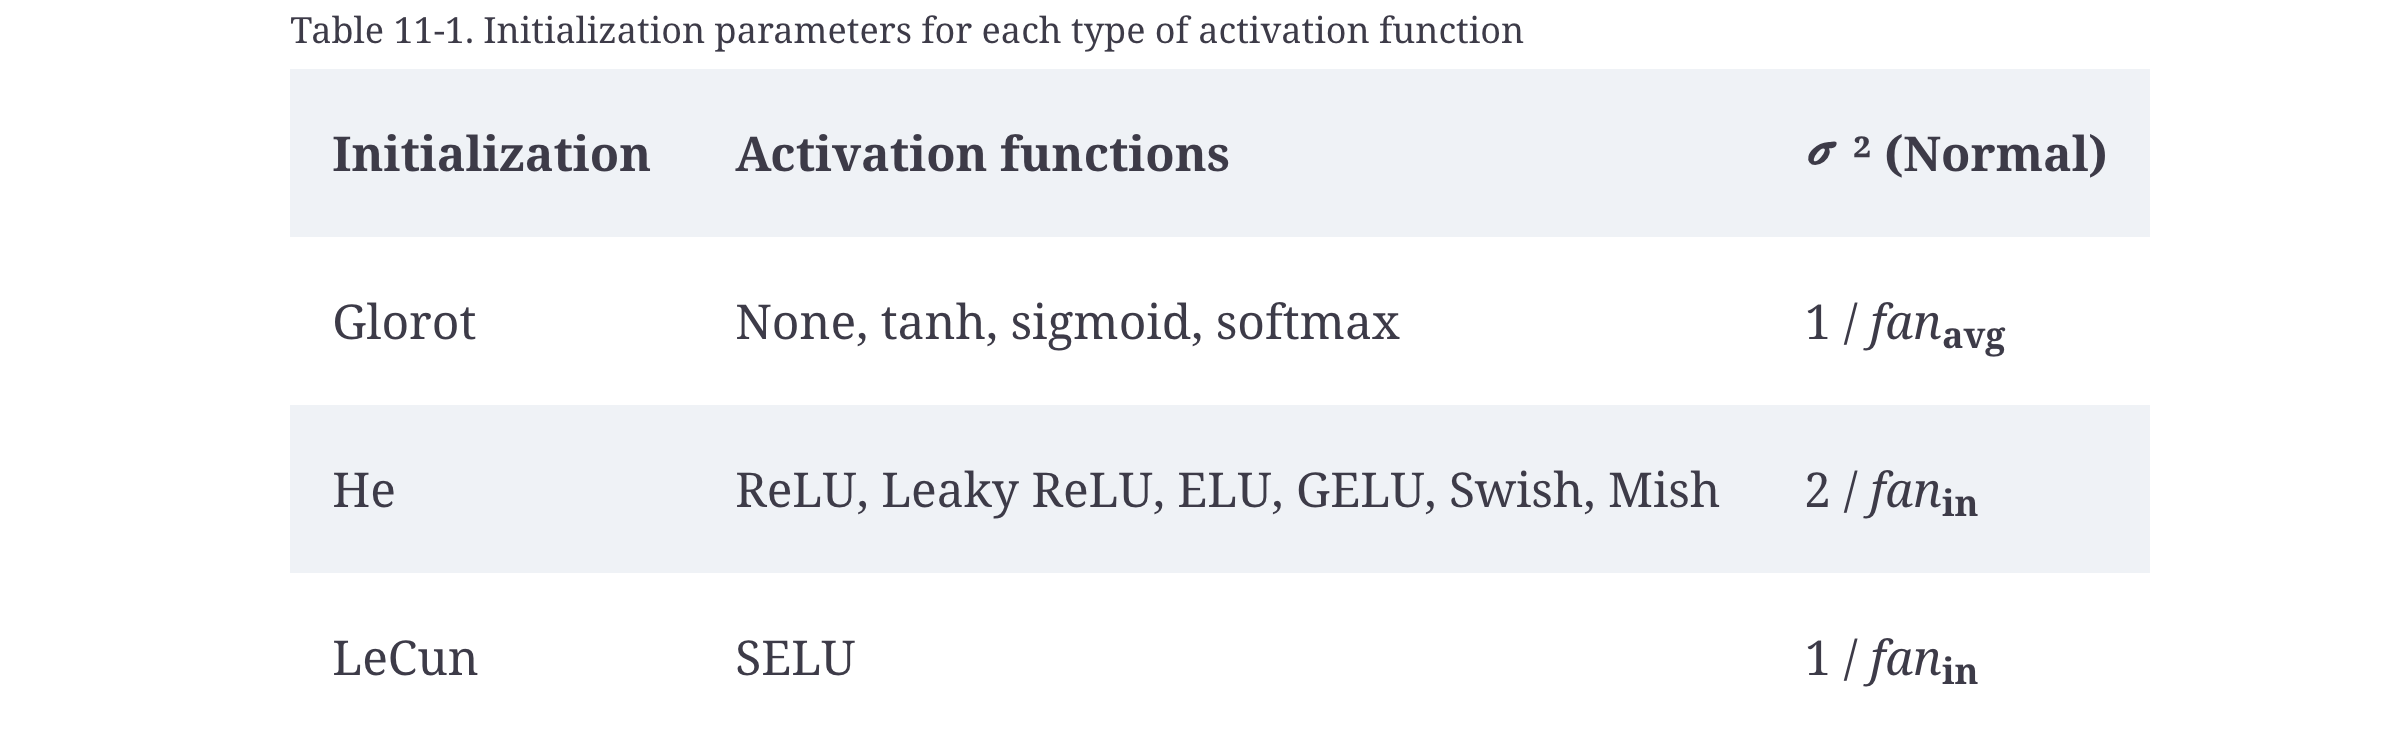

케라스는 기본적으로 균등분포의 글로럿 초기화를 사용한다. 층을 만들 때 He 초기화를 사용하고 싶다면 kernel_initializer="he_normal" 또는 kernel_initializer="he_uniform"으로 바꾸면 된다.

In [3]:
import tensorflow as tf
from tensorflow import keras

dense = tf.keras.layers.Dense(50, activation="relu",
                             kernel_initializer="he_normal")

$fan_{in}$ 대신 $fan_{avg}$ 기반의 균등분포 He 초기화를 사용하고 싶다면 아래와 같이 VarianceScaling을 사용할 수 있다.

In [7]:
he_avg_init = tf.keras.initializers.VarianceScaling(scale=2., mode="fan_avg",
                                                   distribution="uniform")
tf.keras.layers.Dense(50, activation="sigmoid", 
                     kernel_initializer=he_avg_init)

## Better Activation Functions
글로럿과 벤지오의 논문에서 얻은 통찰 중 하나는 활성화 함수를 잘못 선택하면 자칫 vanishing/exploding 그레디언트로 이어질 수 있다는 것이다. 이전에는 시그모이드 함수가 최선의 선택일 것이라고 생각했지만 DNN에서는 다른 활성화 함수가 훨씬 더 잘 작동한다는 사실이 밝혀졌다.   
특히 ReLU는 특정 양숫값에 수렴하지 않고 계산이 빠르다는 큰 장점이 있다. 하지만 완벽하지는 않다. 훈련하는 동안 일부 뉴런이 0만을 출력할 수 있다. 이것을 죽은 ReLU라고 한다.   
뉴런의 가중치가 바뀌어 훈련 세트에 있는 모든 샘플에 대한 입력 가중치의 합이 음수가 되면 뉴런이 죽는다. 가중치 합이 음수이면 ReLU 함수의 그레디언트가 0이 되므로 경사 하강법이 더는 작동하지 않는다. 즉 음수 값들은 모두 그레디언트가 0이 되어 죽은 ReLU가 되어 경사 하강법이 작동하지 않는다.    
> **DNN의 은닉층에는 어떤 활성화 함수를 써야 할까?**<br>
> 일반적으로 SELU > ELU > LeakyReLU(ReLU 변종들) > ReLU > tanh > logistic 순이다.
> - 네트워크가 자기 정규화되지 못하는 구조라면 ELU가 SELU보다 성능이 나을 수도 있다.(SELU가 z=0에서 연속적이지 않기 때문에)
> - 실행 속도가 중요하다면 LeakyReLU를 선택할 수 있다.
> - 시간과 컴퓨팅 리소스가 충분하다면 교차 검증을 통해 여러 활성화 함수를 평가해볼 수 있다.
> - 신경망이 overfitting 되었다면 RReLU, 훈련 셋이 아주 크다면 PReLU를 포함시키는 것이 좋다.
> - ReLU가 가장 널리 사용되는 활성화 함수이므로 라이브러리 등이 ReLU에 최적화 되어있다. 따라서 속도가 중요하다면 ReLU가 좋은 선택일 것이다.
### Leaky ReLU
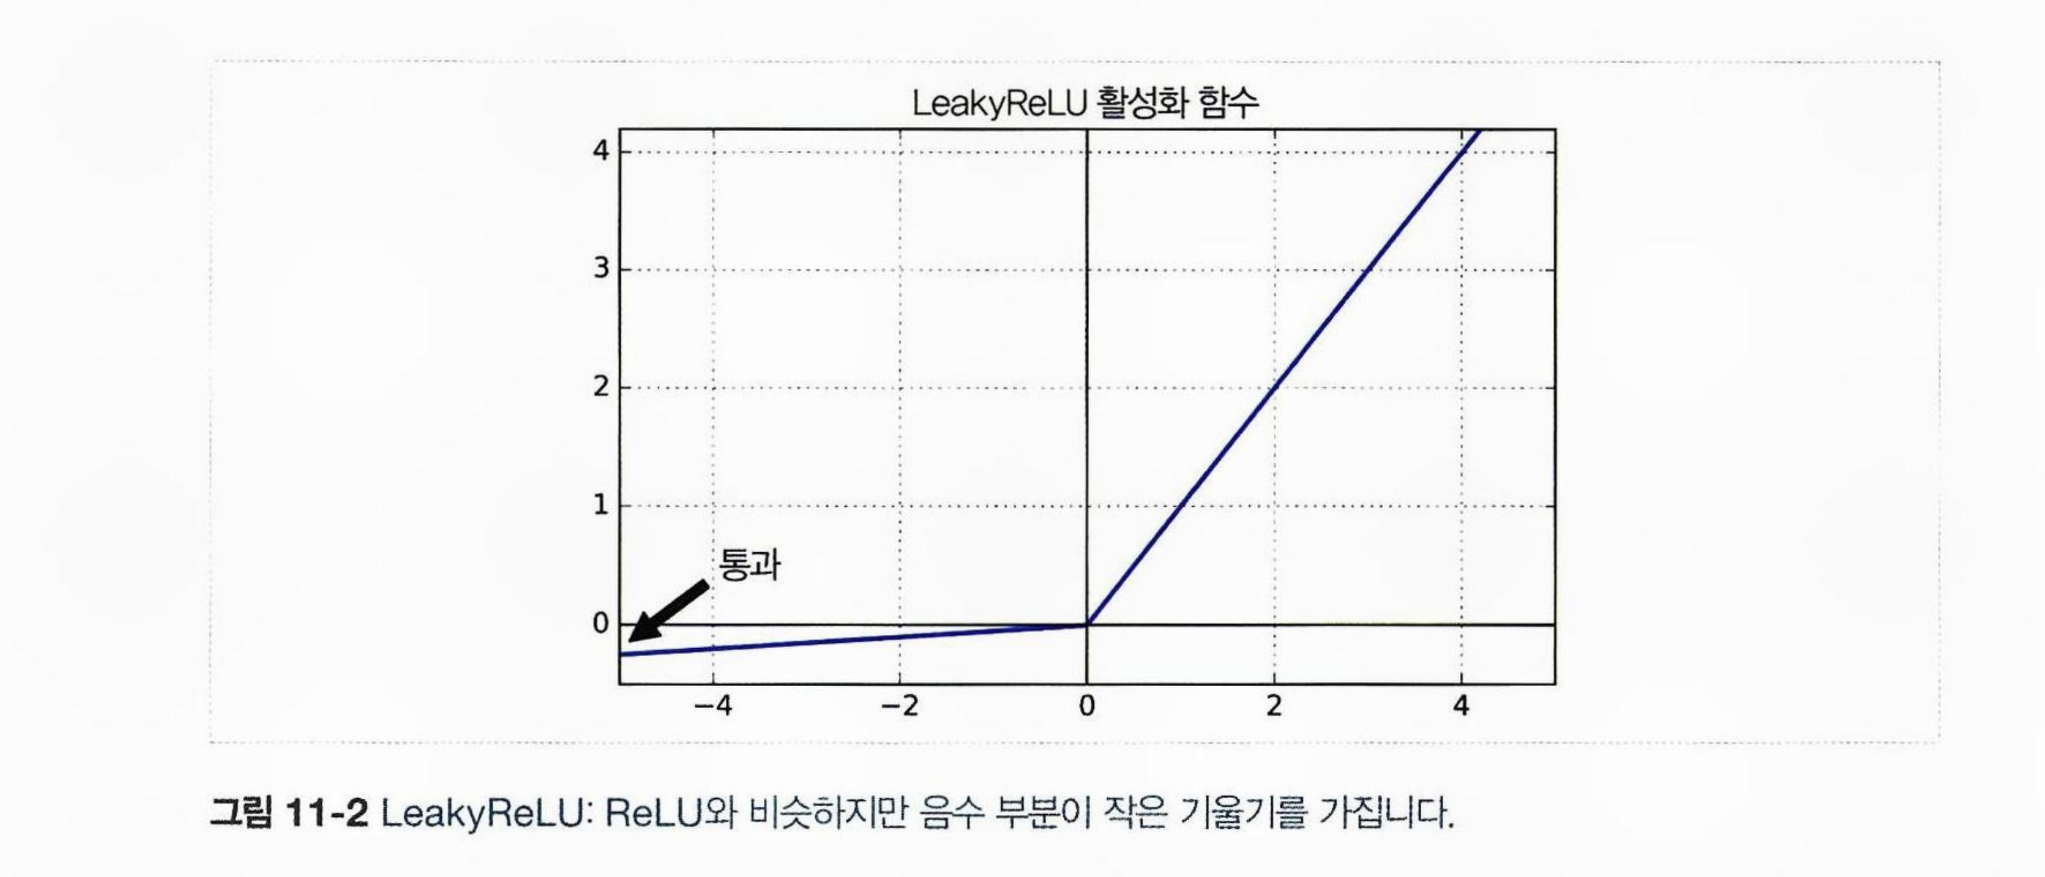<br>
이 문제를 해결하기 위해 Leaky ReLU와 같은 ReLU의 변종을 사용한다. Leaky ReLU는 음수 값도 어느 정도 반영하여 그레디언트가 0이 되지 않도록 해준다. 하이퍼파라미터 ${\alpha}$가 "leaks"한 정도를 결정한다. leaks한 정도란 **z < 0일 때 함수의 기울기**이며, 일반적으로 0.01로 설정한다. 이 작은 기울기가 LeakyReLU를 절대 죽지 않게 해준다.

In [8]:
leaky_relu = tf.keras.layers.LeakyReLU(alpha=0.2) # default alpha=0.3
# prelu = tf.keras.layers.PReLU(alpha=0.2) # PReLU
dense = tf.keras.layers.Dense(50, activation=leaky_relu,
                             kernel_initializer="he_normal")

In [11]:
model = tf.keras.models.Sequential([
    # 다른 층
    tf.keras.layers.Dense(50, kernel_initializer="he_normal"),
    tf.keras.layers.LeakyReLU(alpha=0.2),
    # 다른 층

])

### ELU(Exponential linear unit) 
몇 가지를 제외하고는 ReLU와 매우 비슷하다.
- z < 0일 때 음숫값이 들어오므로 활성화 함수의 평균 출력이 0에 더 가까워 진다. 이는 vanishing gragient 문제를 완화해준다. 하이퍼파라미터 ${\alpha}$는 z가 큰 음숫값일 때 ELU가 수렴할 값의 역수를 정의한다. 보통 1로 한다.
- ${\alpha}$ = 1이면 이 함수는 z=0에서 급격히 변동하지 않으므로 z=0을 포함해 모든 구간에서 매끄어워 경사 하강법의 속도를 높여준다.
- ELU의 주요 단점은 지수 함수를 사용하기 때문에 ReLU나 다른 ReLU의 변종들보다 계산이 느리다는 것이다.
### SELU(Scaled ELU)
스케일이 조정된 ELU 함수의 변종이다.   
귄텀 클람바우어는 논문에서 완전 연결 층만 쌓아서 신경망을 만들고 모든 은닉층이 SELU 함수를 사용한다면 네트워크가 자기 정규화(self-nomalize)된다는 것을 보였다. 훈련하는 동안 각 층의 출력이 평균 0과 1을 유지하는 경향이 있다. 이는 그레디언트 vanishing과 exploding 문제를 막아준다. 그러나 자기 정규화가 일어나기 위해서는 몇 가지 조건을 충족해야 한다.
- 입력 특성이 반드시 표준화(평균 0, 표준편차 1)되어야 한다.
- 모든 은닉층의 가중치는 르쿤 정규분포 초기화로 초기화되어야 한다. (케라스에서는 `kernel_initializer="lecun_normal"`로 설정)
- 네트워크는 일렬로 쌓은 층으로 구성되어야 한다. RNN이나 스킵 연결과 같이 순차적이지 않은 구조에 SELU를 사용하면 자기 정규화되는 것이 보장되지 않는다.

In [12]:
# 사용법
layer = keras.layers.Dense(10, activation="selu",
                          kernel_initializer="lecun_normal")

In [38]:
# SELU 활성화 함수를 사용하여 100개의 은닉층이 있는 패션 MNIST용 신경망 
tf.random.set_seed(42)
model = tf.keras.Sequential()
model.add(tf.keras.layers.Flatten(input_shape=[28, 28]))
for layer in range(100):
    model.add(tf.keras.layers.Dense(100, activation="selu",
                                   kernel_initializer="lecun_normal"))
model.add(tf.keras.layers.Dense(10, activation="softmax"))

model.compile(loss="sparse_categorical_crossentropy",
             optimizer=tf.keras.optimizers.legacy.SGD(learning_rate=0.001),
             metrics=["accuracy"])
  

In [14]:
# data split
fashion_mnist = tf.keras.datasets.fashion_mnist.load_data()
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist
X_train, y_train = X_train_full[:-5000], y_train_full[:-5000]
X_valid, y_valid = X_train_full[-5000:], y_train_full[-5000:]
X_train, X_valid, X_test = X_train / 255., X_valid/255., X_test/255.

In [15]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

In [16]:
# 입력값을 평균 0, 표준편차 1로 스케일링 -> selu 사용 조건
pixel_means = X_train.mean(axis=0, keepdims=True)
pixel_stds = X_train.std(axis=0, keepdims=True)
X_train_scaled = (X_train - pixel_means) / pixel_stds
X_valid_scaled = (X_valid - pixel_means) / pixel_stds
X_test_scaled = (X_test - pixel_means) / pixel_stds

In [17]:
history = model.fit(X_train_scaled,y_train, epochs=5,
                   validation_data=(X_valid_scaled, y_valid))

Epoch 1/5


2023-07-24 16:55:31.962342: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


1719/1719 [==============================] - 16s 9ms/step - loss: 1.4049 - accuracy: 0.4538 - val_loss: 0.9188 - val_accuracy: 0.6758
Epoch 2/5
1719/1719 [==============================] - 15s 9ms/step - loss: 0.8238 - accuracy: 0.6930 - val_loss: 0.7615 - val_accuracy: 0.7428
Epoch 3/5
1719/1719 [==============================] - 15s 9ms/step - loss: 0.6842 - accuracy: 0.7524 - val_loss: 0.6153 - val_accuracy: 0.7840
Epoch 4/5
1719/1719 [==============================] - 15s 9ms/step - loss: 0.6145 - accuracy: 0.7802 - val_loss: 0.5606 - val_accuracy: 0.8070
Epoch 5/5
1719/1719 [==============================] - 15s 9ms/step - loss: 0.5489 - accuracy: 0.8089 - val_loss: 0.5044 - val_accuracy: 0.8182


## Batch Normalization
이 기법은 각 층에서 활성화 함수를 통과하기 전이나 후에 모델에 연산 하나(배치 정규화)를 추가한다. 훈련하는 동안 배치 정규화는 **입력을 원점에 맞추고 정규화**한 다음 각 층에서 **두 개의 새로운 파라미터**로 **결괏값의 스케일을 조정하고 이동**시킨다.    

- 파라미터 하나는 스케일 조정(${\gamma}$)에, 다른 하는 이동(${\beta}$)에 사용한다.
- 많은 경우 신경망의 첫 번째 층으로 배치 정규화를 추가하면 StandardScaler를 이용하여 표준화할 필요가 없다. 배치 정규화 층이 이 역할을 대신하기 때문이다.
- 인풋 데이터를 원점에 맞추고 정규화하려면 알고리즘은 평균과 표준편차를 추정해야 한다. 이를 위해 현재 미니배치에서 입력의 평균과 표준편차를 평가한다.

> 정리하면,
>  배치 정규화 층마다 네 개의 파라미터 벡터가 학습된다.
> 1. ${\gamma}$ : 출력 스케일 벡터
> 2. ${\beta}$ : 출력 이동 벡터
> 3. ${\mu}$ : 최종 입력 평균 벡터
> 4. ${\sigma}$ : 최종 입력 표준편차 벡터
>    → ${\mu}$와 ${\sigma}$는 훈련하는 동안 추정되지만 훈련이 끝난 후에 사용된다.<br>

> ⚠️ 배치 정규화는 모델의 복잡도를 키운다. 실행 시간 면에서도 손해이다. 하지만  배치 정규화를 사용하면 수렴이 훨씬 빨라지므로 보통 상쇄된다. 따라서 더 작은 에포크로 동일한 성능에 도달할 수 있다. 대체로 실제 걸리는 시간은 더 짧다.

### Implementing batch normalization with Keras
은닉층의 활성화 함수 전이나 후에 `BatchNormalization` 층을 추가하면 된다. 모델의 첫 번째 층으로 배치 정규화 층을 추가할 수도 있다.

In [18]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)

In [22]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28,28]),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(300, activation="relu",
                         kernel_initializer="he_normal"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(100, activation="relu",
                         kernel_initializer="he_normal"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(100, activation="softmax")
])

In [23]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 batch_normalization_3 (Batc  (None, 784)              3136      
 hNormalization)                                                 
                                                                 
 dense_3 (Dense)             (None, 300)               235500    
                                                                 
 batch_normalization_4 (Batc  (None, 300)              1200      
 hNormalization)                                                 
                                                                 
 dense_4 (Dense)             (None, 100)               30100     
                                                                 
 batch_normalization_5 (Batc  (None, 100)             

In [24]:
# 배치 정규화 층은 입력마다 네 개의 파라미터를 추가함
[(var.name, var.trainable) for var in model.layers[1].variables]

[('batch_normalization_3/gamma:0', True),
 ('batch_normalization_3/beta:0', True),
 ('batch_normalization_3/moving_mean:0', False),
 ('batch_normalization_3/moving_variance:0', False)]

var.trainable = True는 역전파로 학습되는 파라미터이고, False는 역전파로 학습되지 않는 파라미터로 케라스는 'Non-trainable' 파라미터로 분류한다.    
- 배치 정규화 파라미터의 전체 개수는 3136 + 1200 + 400 = 4736개 인데, 이것을 2로 나누면 이 모델에서 훈련되지 않는 Non-trainable 파라미터 개수인 2368을 얻게 된다.

In [34]:
# model.layers[1].variables

In [35]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="sgd",
             metrics="accuracy")
model.fit(X_train, y_train, epochs=2, validation_data=(X_valid, y_valid))

Epoch 1/2
1719/1719 [==============================] - 3s 1ms/step - loss: 0.7061 - accuracy: 0.7996 - val_loss: 0.4201 - val_accuracy: 0.8520
Epoch 2/2
1719/1719 [==============================] - 3s 1ms/step - loss: 0.4389 - accuracy: 0.8490 - val_loss: 0.3709 - val_accuracy: 0.8664


## Gradient Clipping
Gradient Clipping은 역전파될 때 일정 임계값을 넘어서지 못하게 그레디언트를 잘라내는 것으로 그레디언트 exploding 문제를 완화하는 방법이다. RNN의 경우 배치 정규화를 적용하기 어렵기 때문에 이 방법을 많이 사용한다. 다른 종류의 네트워크는 배치 정규화면 충분하다.   
keras에서 Gradient Clipping을 구현하려면 opimizer를 만들 때 clipvalue와 clipnorm 매개변수를 지정하면 된다.

아래의 옵티마이저는 그레디언트 벡터의 모든 원소를 -1.0과 1.0 사이로 클리핑한다. 즉 훈련되는 각 파라미터에 대한 손실의 모든 편미분 값을 -1.0에서 1.0으로 잘라낸다. 임곗값은 하이퍼파라미터로 튜닝할 수 있다.

In [37]:
optimizer = keras.optimizers.legacy.SGD(clipvalue=1.0)
model.compile(loss="mse", optimizer=optimizer)

만약 Gradient Clipping이 그레디언트 벡터의 방향을 바꾸지 못하게 하려면 clipvalue 대신 clipnorm을 지정하여 노름으로 클리핑해야 한다.

In [40]:
optimizer = keras.optimizers.legacy.SGD(clipnorm=1.0)
model.compile(loss="mse", optimizer=optimizer)

# 2. Reusing Pretrained Layers
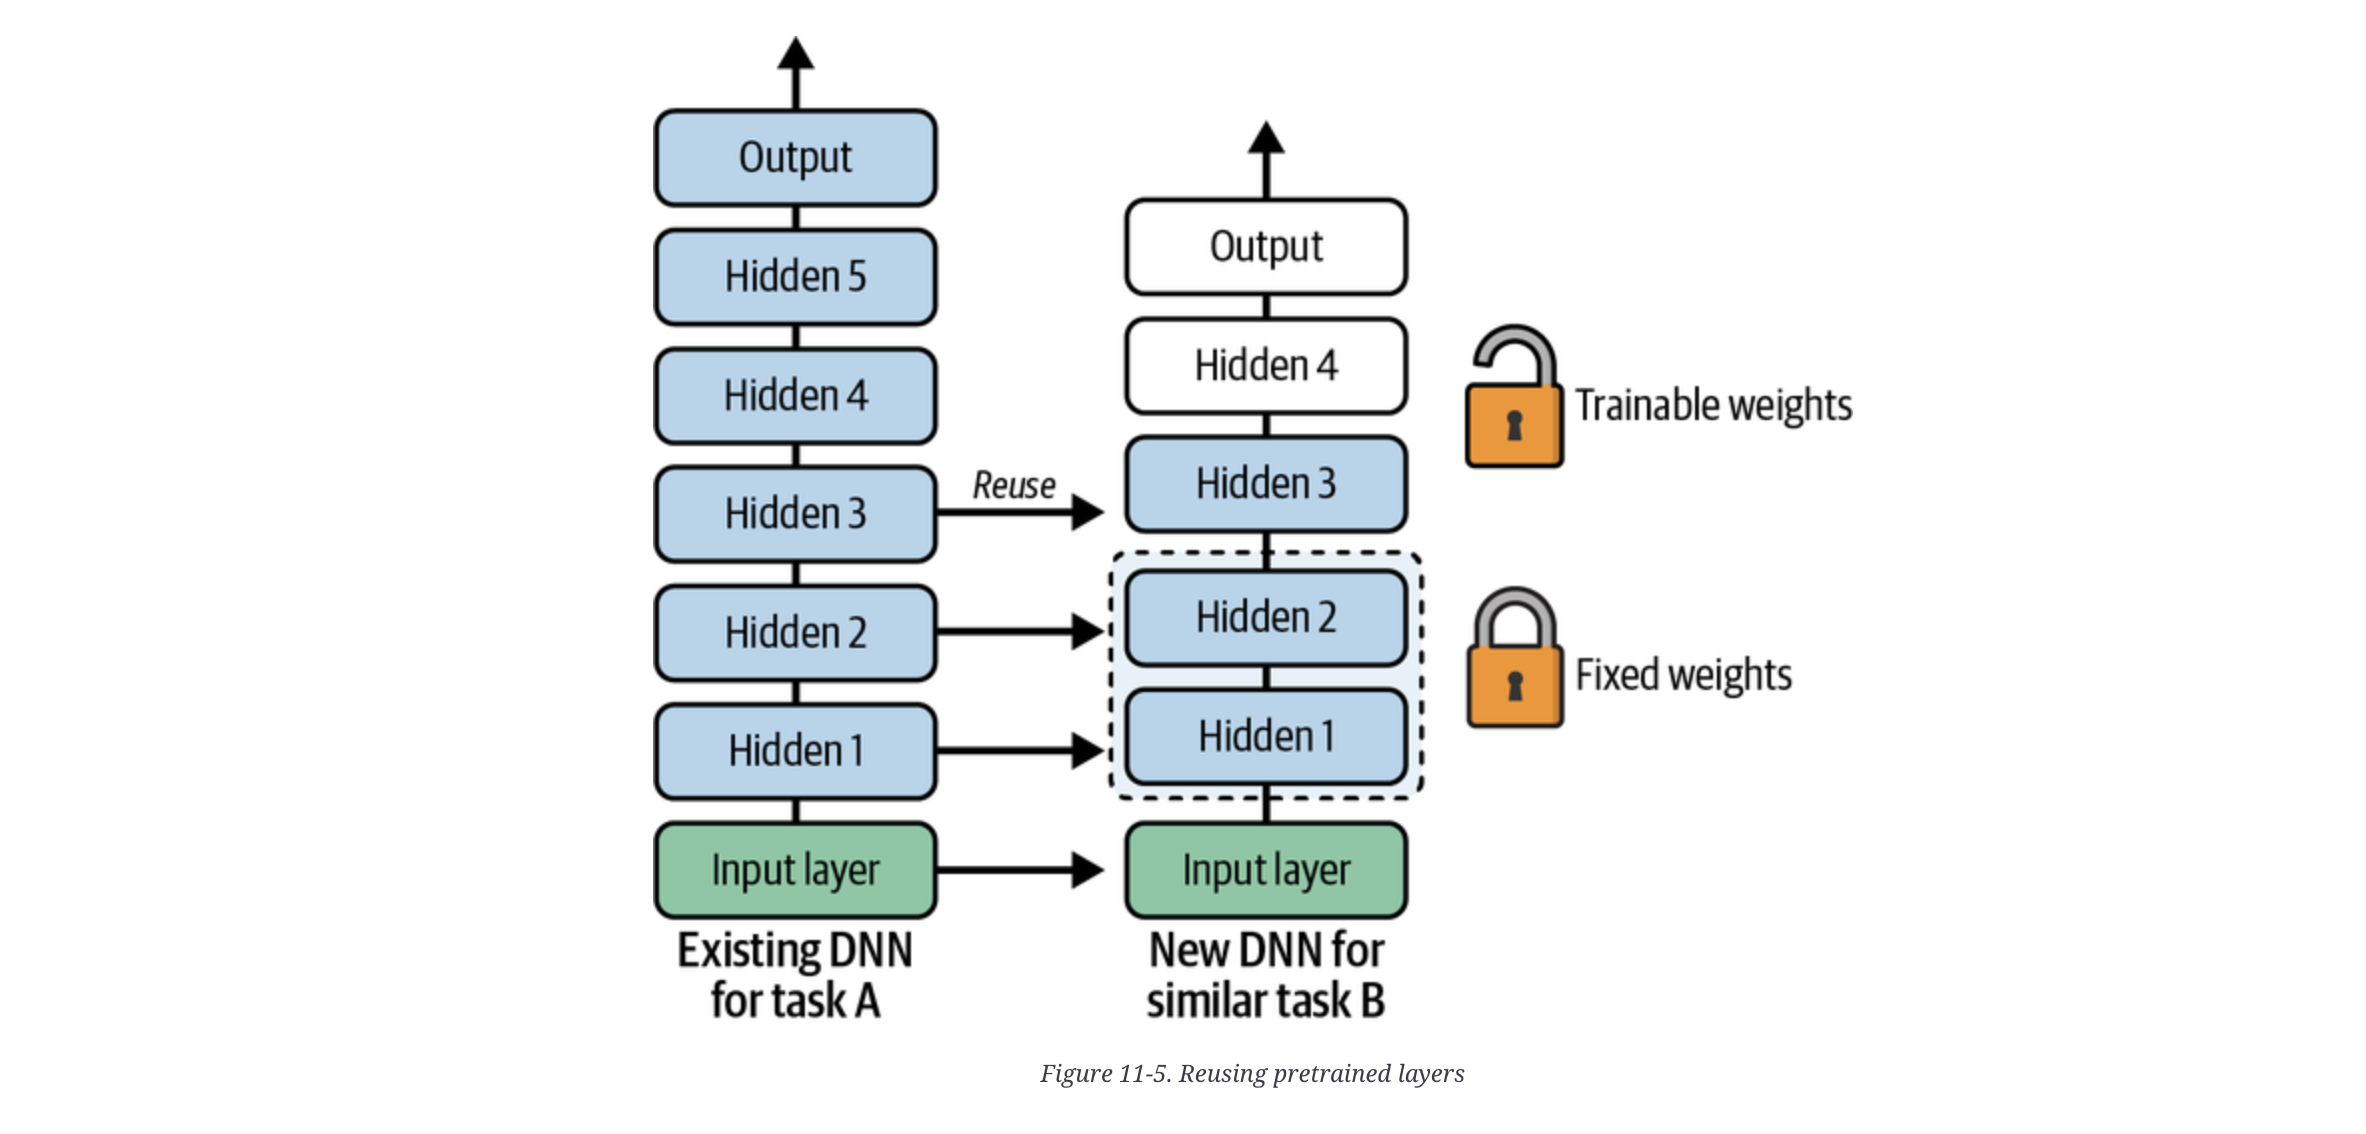<br>
일반적으로 아주 큰 규모의 DNN을 처음부터 새로 훈련하는 것은 좋은 생각이 아니다. 해결 하려는 것과 비슷한 유형의 문제를 처리한 신경망이 이미 있는지 찾아본 다음, 그 신경망의 하위층을 재사용하는 것이 좋다. 이를 **전이 학습**이라고 한다.   
보통 원본 모델의 출력층을 바꿔야 한다. 이 층은 새로운 작업에 필요한 출력 개수와 맞지 않을 수도 있기 때문이다.  
풀려는 문제가 비슷할 수록 낮은 층부터 시작해서 점차 상위의 은닉층을 재사용한다. 아주 비슷한 작업이라면 모든 은닉층을 유지하고 출력층만 교체한다.<br>
1. 먼저 경사 하강법으로 가중치가 바뀌지 않도록 재사용하는 층을 모두 freezing 한다.
2. 모델을 훈련하고 성능 평가를 한다.
3. 맨 위에 있는 한두개의 은닉층의 동결을 해제하고 역전파를 통해 가중치를 조정하여 성능이 향상되는지 확인한다. 훈련 데이터가 많을수록 많은 층의 동결을 해제할 수 있다.<br>
       → 많은 층의 동결을 해제할 때는 학습률을 줄이는 것이 좋다. 가중치를 세밀하게 튜닝하는 데 도움이 되기 때문이다.
4. 여전히 성능이 안나오고 훈련 데이터가 적다면 상위 은닉층들을 제거하고 남은 은닉층을 다시 freezing 해본다. 이런 식으로 재사용할 은닉층의 적정한 개수를 찾을 때까지 반복한다.<br>
        → 훈련 데이터가 아주 많다면 은닉층을 제거하는 대신 다른 것으로 바꾸거나 더 많은 은닉층을 추가할 수도 있다.

## Transfer Learning with Keras
⬇︎ 패션 MNIST를 작업 A와 B로 분할한 다음 모델 A를 학습하고 "my_model_A"에 저장

In [43]:
# 추가 코드 - 패션 MNIST를 작업 A와 B로 분할한 다음 모델 A를 학습하고 "my_model_A"에 저장합니다.
import numpy as np

pos_class_id = class_names.index("Pullover")
neg_class_id = class_names.index("T-shirt/top")

def split_dataset(X, y):
    y_for_B = (y == pos_class_id) | (y == neg_class_id)
    y_A = y[~y_for_B]
    y_B = (y[y_for_B] == pos_class_id).astype(np.float32)
    old_class_ids = list(set(range(10)) - set([neg_class_id, pos_class_id]))
    for old_class_id, new_class_id in zip(old_class_ids, range(8)):
        y_A[y_A == old_class_id] = new_class_id  # A에 대한 클래스 ID 재정의
    return ((X[~y_for_B], y_A), (X[y_for_B], y_B))

(X_train_A, y_train_A), (X_train_B, y_train_B) = split_dataset(X_train, y_train)
(X_valid_A, y_valid_A), (X_valid_B, y_valid_B) = split_dataset(X_valid, y_valid)
(X_test_A, y_test_A), (X_test_B, y_test_B) = split_dataset(X_test, y_test)
X_train_B = X_train_B[:200]
y_train_B = y_train_B[:200]

tf.random.set_seed(42)

model_A = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dense(8, activation="softmax")
])

model_A.compile(loss="sparse_categorical_crossentropy",
                optimizer=tf.keras.optimizers.legacy.SGD(learning_rate=0.001),
                metrics=["accuracy"])
history = model_A.fit(X_train_A, y_train_A, epochs=20,
                      validation_data=(X_valid_A, y_valid_A))
model_A.save("my_model_A")

Epoch 1/20
1376/1376 [==============================] - 1s 711us/step - loss: 1.2400 - accuracy: 0.6463 - val_loss: 0.7201 - val_accuracy: 0.7967
Epoch 2/20
1376/1376 [==============================] - 1s 651us/step - loss: 0.6059 - accuracy: 0.8205 - val_loss: 0.5092 - val_accuracy: 0.8378
Epoch 3/20
1376/1376 [==============================] - 1s 710us/step - loss: 0.4779 - accuracy: 0.8515 - val_loss: 0.4348 - val_accuracy: 0.8569
Epoch 4/20
1376/1376 [==============================] - 1s 670us/step - loss: 0.4192 - accuracy: 0.8641 - val_loss: 0.3908 - val_accuracy: 0.8719
Epoch 5/20
1376/1376 [==============================] - 1s 657us/step - loss: 0.3836 - accuracy: 0.8739 - val_loss: 0.3640 - val_accuracy: 0.8764
Epoch 6/20
1376/1376 [==============================] - 1s 677us/step - loss: 0.3590 - accuracy: 0.8811 - val_loss: 0.3449 - val_accuracy: 0.8837
Epoch 7/20
1376/1376 [==============================] - 1s 651us/step - loss: 0.3413 - accuracy: 0.8844 - val_loss: 0.3312 -

INFO:tensorflow:Assets written to: my_model_A/assets


model_B_on_A와 model_A는 층을 실제 공유하므로 하나를 훈련하면 두 모델이 모두 업데이트됩니다. 이를 방지하려면 model_A의 복제하여 model_B_on_A를 만들어야 한다.

In [47]:
tf.random.set_seed(42) 

# 기존 model_A에 영향이 가지 않도록 clone해서 쓰기
model_A_clone = tf.keras.models.clone_model(model_A)
model_A_clone.set_weights(model_A.get_weights())

# model_A_clone을 기반으로 새로운 모델 model_B_on_A를 만든다.
model_B_on_A = tf.keras.Sequential(model_A_clone.layers[:-1]) # 출력층 제외하고 모든 층 재사용
model_B_on_A.add(tf.keras.layers.Dense(1, activation="sigmoid"))

# 새로운 출력층은 랜덤 초기화 되어있어 오차가 클 것임. 처음 몇 번의 에포크 동안 재사용된 층을 동결하고 새로운 층에 적절한 가중치를 학습할 시간 주기
for layer in model_B_on_A.layers[:-1]:
    layer.trainable = False # 모든 층의 trainable 속성을 False로 지정

# 모델 컴파일
optimizer = tf.keras.optimizers.legacy.SGD(learning_rate=0.001)
model_B_on_A.compile(loss="binary_crossentropy", optimizer=optimizer,
                     metrics=["accuracy"])
history = model_B_on_A.fit(X_train_B, y_train_B, epochs=4,
                           validation_data=(X_valid_B, y_valid_B))
# 재사용된 층의 동결을 해제
for layer in model_B_on_A.layers[:-1]:
    layer.trainable = True

# 다시 컴파일
optimizer = tf.keras.optimizers.legacy.SGD(learning_rate=0.001)
model_B_on_A.compile(loss="binary_crossentropy", optimizer=optimizer,
                     metrics=["accuracy"])
history = model_B_on_A.fit(X_train_B, y_train_B, epochs=16,
                           validation_data=(X_valid_B, y_valid_B))

Epoch 1/4
7/7 [==============================] - 0s 15ms/step - loss: 1.1368 - accuracy: 0.5600 - val_loss: 0.9023 - val_accuracy: 0.4698
Epoch 2/4
7/7 [==============================] - 0s 5ms/step - loss: 0.8185 - accuracy: 0.4550 - val_loss: 0.8186 - val_accuracy: 0.3907
Epoch 3/4
7/7 [==============================] - 0s 5ms/step - loss: 0.7808 - accuracy: 0.4150 - val_loss: 0.8073 - val_accuracy: 0.4204
Epoch 4/4
7/7 [==============================] - 0s 5ms/step - loss: 0.7580 - accuracy: 0.4900 - val_loss: 0.7833 - val_accuracy: 0.4411
Epoch 1/16
7/7 [==============================] - 0s 14ms/step - loss: 0.7181 - accuracy: 0.5400 - val_loss: 0.7108 - val_accuracy: 0.5232
Epoch 2/16
7/7 [==============================] - 0s 5ms/step - loss: 0.6493 - accuracy: 0.6350 - val_loss: 0.6423 - val_accuracy: 0.6538
Epoch 3/16
7/7 [==============================] - 0s 5ms/step - loss: 0.5843 - accuracy: 0.7400 - val_loss: 0.6028 - val_accuracy: 0.6924
Epoch 4/16
7/7 [====================

In [48]:
model_B_on_A.evaluate(X_test_B, y_test_B)

63/63 [==============================] - 0s 577us/step - loss: 0.3345 - accuracy: 0.9050


[0.3344813287258148, 0.9049999713897705]

# Faster Optimizers